# Introduction

For this project, the house prices from the Ames Housing test dataset will be predicted. There are two datasets that will be imported from this competition:

- Training dataset "train.csv" for whom the Supervised Learning Models will be trained upon;
- Test dataset "test.csv" where the house prices will be predicted.

# Acknowledgements

The work presented was inspired from the Machine Learning Tutorials I have gone through here on Kaggle and from other sources. I would also like to thank [A. Qua](https://www.kaggle.com/adibouayjan) and his [notebook](https://www.kaggle.com/code/adibouayjan/house-price-step-by-step-modeling) which provided the inspiration for this notebook and I highly recommended looking through if you want to pick up some important techniques with regards to exploratory data analysis, feature engineering and training and analysis of supervised learning models.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Model functions
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Statistics functions
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# Functions to calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Function to split data into different groups
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold

# Function to deal with missing values via imputation
from sklearn.impute import SimpleImputer

# Function that converts categorical values into numerical values via ordinal encoding or one-hot encoding
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

First, we import the training and test datasets from the House Prices Advanced Regression competition into data_train and data_test respectively. As seen by the shape of the two datasets, data_test has one less column than data_train as it does not contain the target variable "SalePrice".

In [2]:
data_train = pd.read_csv('C:/Users/Arjun (Non-admin)/Documents/House Prices/home-data-for-ml-course/train.csv')
data_test = pd.read_csv('C:/Users/Arjun (Non-admin)/Documents/House Prices/home-data-for-ml-course/test.csv')

print(f"Training set shape: {data_train.shape}\n")
print(f"Test set shape: {data_test.shape}\n")

Training set shape: (1460, 81)

Test set shape: (1459, 80)



In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Looking at the information from the data_train DataFrame, we see that some of these columns have missing values. These missing values will be dealt with later. But before we do some exploratory data analysis and feature engineering, we check to see that both datasets have the same feature variables (i.e. they both have the same columns except for "SalePrice" in data_train).

In [4]:
# Checking if column headings are the same in both data set
dif_1 = [x for x in data_train.columns if x not in data_test.columns]
print(f"Columns present in df_train and absent in df_test: {dif_1}\n")

dif_2 = [x for x in data_test.columns if x not in data_train.columns]
print(f"Columns present in df_test set and absent in df_train: {dif_2}")

Columns present in df_train and absent in df_test: ['SalePrice']

Columns present in df_test set and absent in df_train: []


Before we proceed investigating the numerical and categorical features from both datasets, the "Id" column will be dropped from both datasets as well. The list of IDs from the test set will be saved so that it can be used later on when we predict the house prices from that dataset.

In [5]:
# Drop the 'Id' column from the training set
data_train.drop(["Id"], axis=1, inplace=True)

# Save the 'Id' list before dropping it from the test set
Id_test_list = data_test["Id"].tolist()
data_test.drop(["Id"], axis=1, inplace=True)

At certain stages of this project, the shape of both datasets will be printed out to clarify that both datasets have had the same features either added on or removed. The shape of both datasets now before we investigate the numerical and categorical features from both datasets stands as follows:

In [6]:
print(f"Training set shape: {data_train.shape}\n")
print(f"Test set shape: {data_test.shape}\n")

Training set shape: (1460, 80)

Test set shape: (1459, 79)



# Numerical Data

Firstly we will focus on the numerical features from both datasets where we will do some exploratory data analysis and some feature engineering to

* Investigate the distribution of these numerical features;
* Investigate the correlation of these numerical features with "SalePrice" and drop any features that have low correlation;
* Deal with missing values through imputation.

To start off with, we select only the numerical columns from data_train (including "SalePrice") by obtaining the list of numerical columns from data_train in numerical_cols, and using this to take out the numerical columns from data_train and store them in a new DataFrame data_train_num (we also do the same thing with the test dataset).

In [7]:
# Select numerical columns from the training dataset
numerical_cols = [cname for cname in data_train.columns if 
                  data_train[cname].dtype in ['int64', 'float64']]

numerical_cols_test = [cname for cname in data_test.columns if 
                      data_test[cname].dtype in ['int64', 'float64']]

data_train_num = data_train[numerical_cols].copy()
data_test_num = data_test[numerical_cols_test].copy()

data_train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


## Distribution

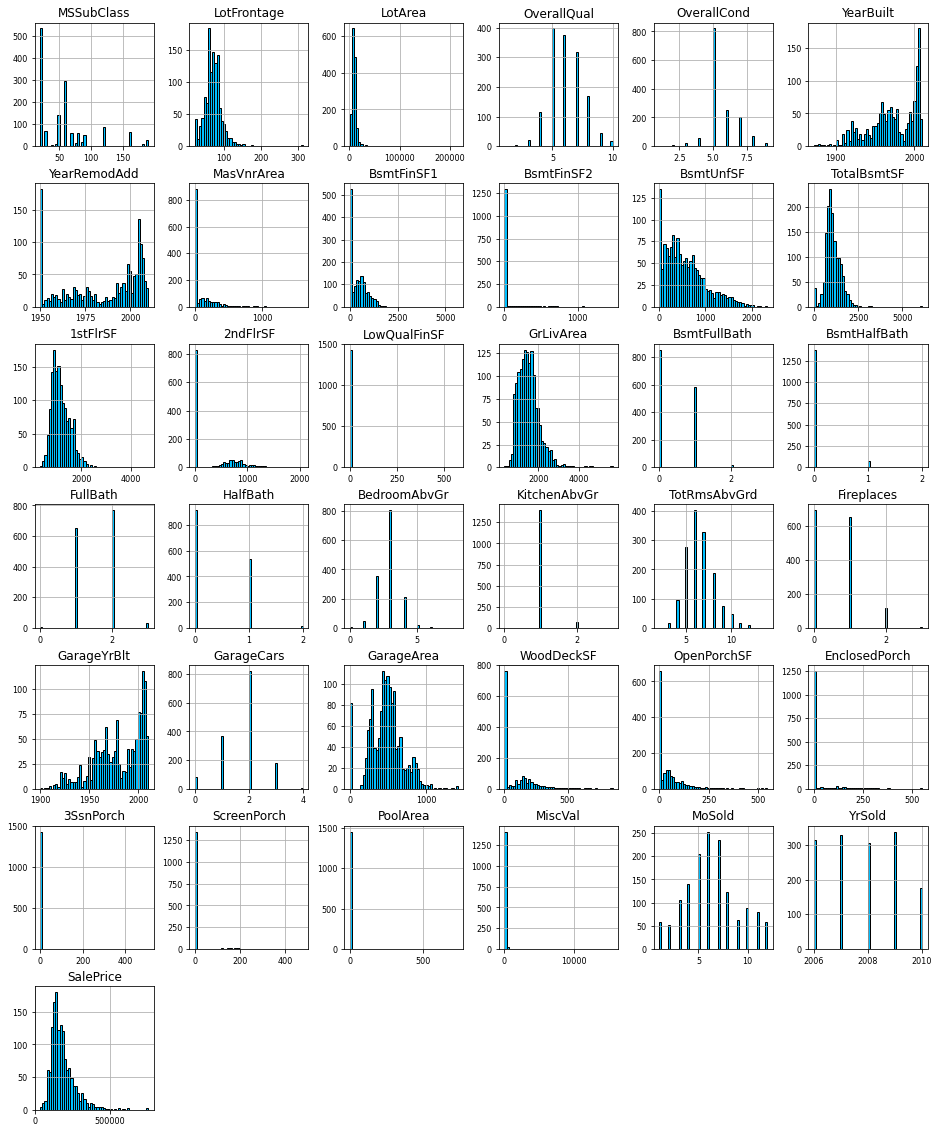

In [8]:
# Plot the distribution of all the numerical features
fig_ = data_train_num.hist(figsize=(16, 20), bins=50, color="deepskyblue",
                           edgecolor="black", xlabelsize=8, ylabelsize=8)

Looking at the distriutions of each numerical feature, we see that there are a variety of distributions on show and that we have a mixture of discrete and continuous variables in our dataset. One thing that we can spot from these plots are variables that has small variation (i.e. they have very similar values) - these variables are likely to only have a small impact on the final price of the house. We will drop any variables where 95% of the values are similar or constant.

In [9]:
# Drop any quasi-constant features where 95% of the values are similar or constant
sel = VarianceThreshold(threshold=0.05) # 0.05: drop column where 95% of the values are constant

# The fit finds the features with constant variance
sel.fit(data_train_num.iloc[:, :-1])


# Get the number of features that are not constant
print(f"Number of retained features: {sum(sel.get_support())}")
print(f"\nNumber of quasi_constant features: {len(data_train_num.iloc[:, :-1].columns) - sum(sel.get_support())}")

quasi_constant_features_list = [x for x in data_train_num.iloc[:, :-1].columns if x not in data_train_num.iloc[:, :-1].columns[sel.get_support()]]

print(f"\nQuasi-constant features to be dropped: {quasi_constant_features_list}")

Number of retained features: 35

Number of quasi_constant features: 1

Quasi-constant features to be dropped: ['KitchenAbvGr']


From this, we see that only one variable "KitchenAbvGr" (Kitchens above the grade) has at least 95% of variables that are similar and constant, so this will be removed from both the training and test datasets.

In [10]:
# Drop quasi-constant features from both datasets
data_train_num.drop(quasi_constant_features_list, axis=1, inplace=True)
data_test_num.drop(quasi_constant_features_list, axis=1, inplace=True)

In [11]:
print(f"Training set shape (Numerical features): {data_train_num.shape}\n")
print(f"Test set shape (Numerical features): {data_test_num.shape}\n")

Training set shape (Numerical features): (1460, 36)

Test set shape (Numerical features): (1459, 35)



## Correlation

We will now produce a correlation heatmap showing the correlation between all of the numerical variables including the correlation of each numerical feature with "SalePrice". Any variables that have a low correlation with "SalePrice" is likely not to have a huge impact on the final sale price of the house, any variables with correlation less than |0.3| will be replaced by 0 for simplicity.

<AxesSubplot:>

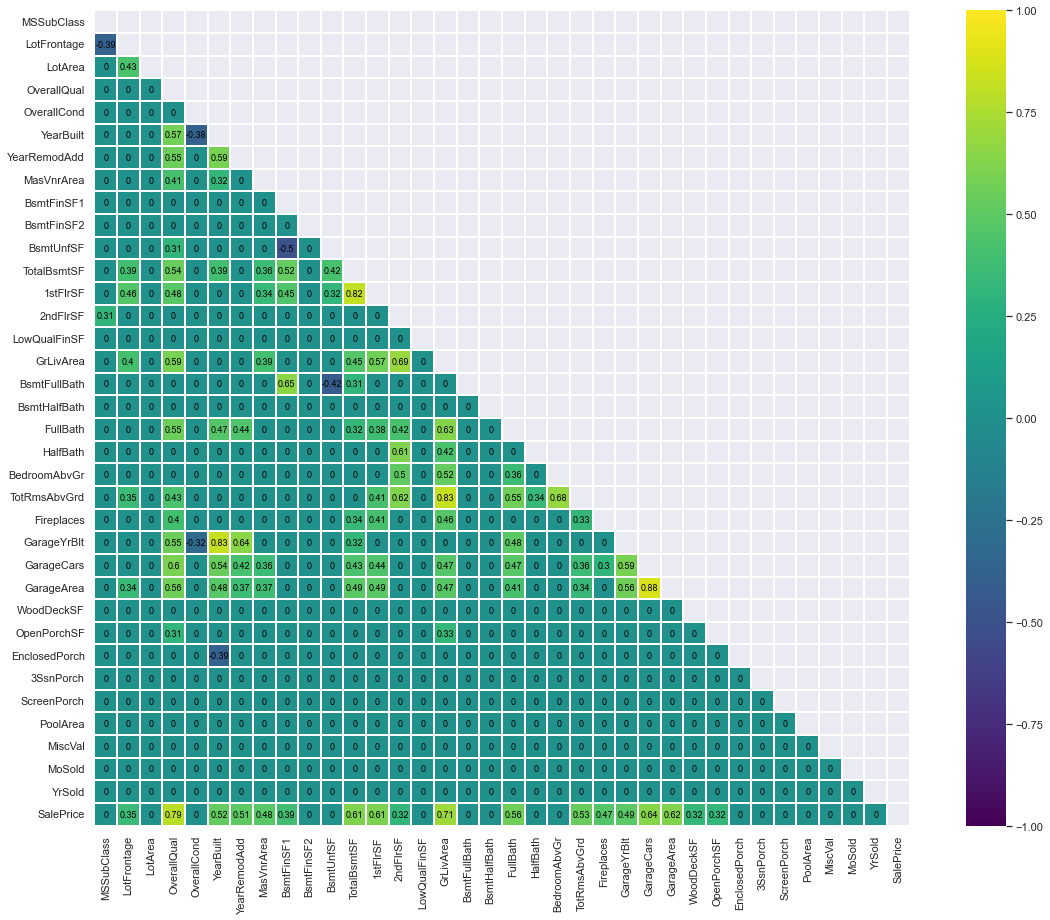

In [12]:
# Heatmap for all the remaining numerical data including the taget 'SalePrice'

# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format

# Define correlation matrix
corr_matrix = data_train_num.corr()

# Replace any correlation < |0.3| by 0 for a better visibility
corr_matrix[(corr_matrix < 0.3) & (corr_matrix > -0.3)] = 0

# Mask the upper part of the heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Choose the color map
cmap = "viridis"

# plot the heatmap
sns.set(rc = {'figure.figsize':(20,15)})
sns.heatmap(corr_matrix, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 9, "color": "black"}, square=True, cmap=cmap, annot=True)

Looking at the heatmap above, we see that 18 of these numerical features has some noticeable correlation with "SalePrice". There are also a few variables that have a very strong positive correlation (of at least 0.8) including

* "GarageArea" and "GarageCars" (0.88)
* "GarageYrBlt" and "YearBuilt" (0.83)
* "TotRmsAbvGrd" and "GrLivArea" (0.83)
* "1stFlrSF" and "TotalBsmtSF" (0.82)

The other correlations will be dealt with later, but first we will focus on features that have a correlaton of more than |0.3| with "SalePrice".

In [13]:
# Select features where the correlation with 'SalePrice' is higher than |0.3|
# -1 because the latest row is SalePrice
data_num_corr = data_train_num.corr()["SalePrice"][:-1]

# Correlated features (r2 > 0.5)
high_features_list = data_num_corr[abs(data_num_corr) >= 0.5].sort_values(ascending=False)
print(f"{len(high_features_list)} strongly correlated values with SalePrice:\n{high_features_list}\n")

# Correlated features (0.3 < r2 < 0.5)
low_features_list = data_num_corr[(abs(data_num_corr) < 0.5) & (abs(data_num_corr) >= 0.3)].sort_values(ascending=False)
print(f"{len(low_features_list)} slightly correlated values with SalePrice:\n{low_features_list}")

10 strongly correlated values with SalePrice:
OverallQual    0.79
GrLivArea      0.71
GarageCars     0.64
GarageArea     0.62
TotalBsmtSF    0.61
1stFlrSF       0.61
FullBath       0.56
TotRmsAbvGrd   0.53
YearBuilt      0.52
YearRemodAdd   0.51
Name: SalePrice, dtype: float64

8 slightly correlated values with SalePrice:
GarageYrBlt   0.49
MasVnrArea    0.48
Fireplaces    0.47
BsmtFinSF1    0.39
LotFrontage   0.35
WoodDeckSF    0.32
2ndFlrSF      0.32
OpenPorchSF   0.32
Name: SalePrice, dtype: float64


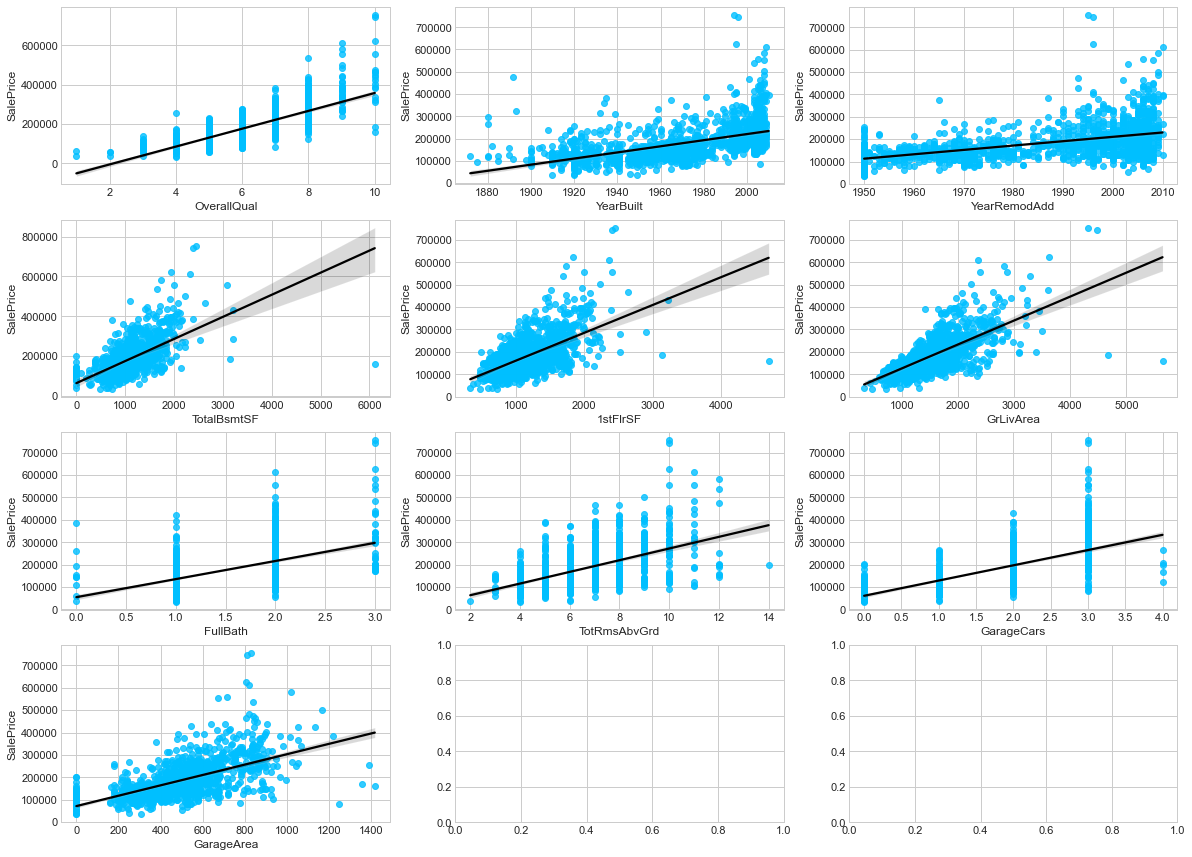

In [14]:
# Features with high correlation (higher than 0.5)
strong_features = data_num_corr[abs(data_num_corr) >= 0.5].index.tolist()
strong_features.append("SalePrice")

data_strong_features = data_train_num.loc[:, strong_features]

plt.style.use("seaborn-whitegrid")  # define figures style
fig, ax = plt.subplots(round(len(strong_features) / 3), 3)

for i, ax in enumerate(fig.axes):
    # plot the correlation of each feature with SalePrice
    if i < len(strong_features)-1:
        sns.regplot(x=strong_features[i], y="SalePrice", data=data_strong_features, ax=ax, scatter_kws={
                    "color": "deepskyblue"}, line_kws={"color": "black"})

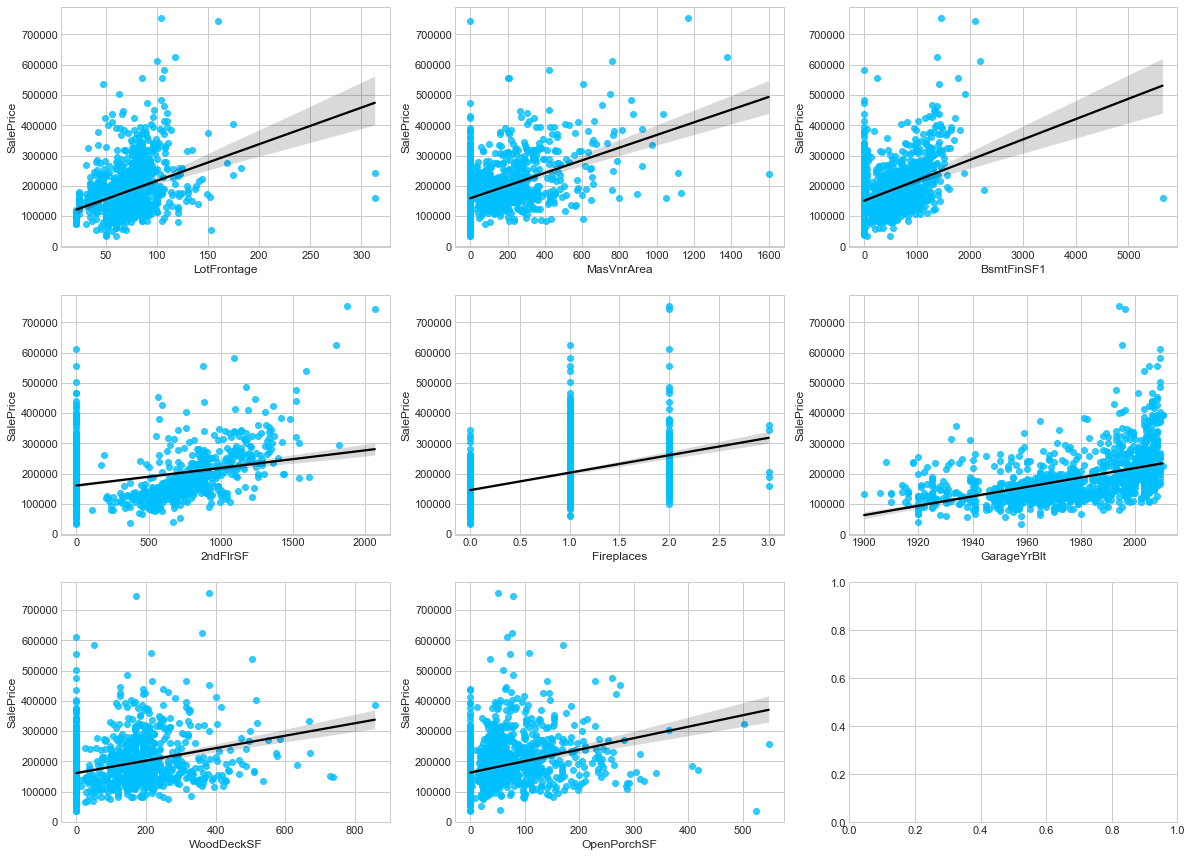

In [15]:
# Features with low correlation (between 0.3 and 0.5)
low_features = data_num_corr[(abs(data_num_corr) >= 0.3) & (abs(data_num_corr) < 0.5)].index.tolist()
low_features.append("SalePrice")

data_low_features = data_train_num.loc[:, low_features]

plt.style.use("seaborn-whitegrid")  # define figures style
fig, ax = plt.subplots(round(len(low_features) / 3), 3)

for i, ax in enumerate(fig.axes):
    # plot the correlation of each feature with SalePrice
    if i < len(low_features) - 1:
        sns.regplot(x=low_features[i], y="SalePrice", data=data_low_features, ax=ax, scatter_kws={
                    "color": "deepskyblue"}, line_kws={"color": "black"},)

Looking at some of these scatter plots related to the surface area of certain rooms in the house ("1stFlrSF", "TotalBsmtSF", "GrLivingArea"), there is at least one house whose price is relatively inexpensive given their surface area (located on the bottom right-hand-side of those graphs) which suggests the presence of outliers in the dataset. These will be dealt with in a future version of this project, but for now we will keep these numerical features shown in the scatter plot above.

In [16]:
# Define the list of numerical fetaures to keep
list_of_numerical_features = strong_features[:-1] + low_features

print("List of features to be kept in the dataset:")
print(list_of_numerical_features)

# Select these features form our training set
data_train_num = data_train_num.loc[:, list_of_numerical_features]

# Select the same features from the test set (-1 -> except 'SalePrice')
data_test_num = data_test_num.loc[:, list_of_numerical_features[:-1]]

List of features to be kept in the dataset:
['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', '2ndFlrSF', 'Fireplaces', 'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']


Looking at the other correlation values beyond "SalePrice", since the correlation between "GarageCars" and "GarageArea" is so high, "GarageCars" will be dropped from both datasets as this is not likely to add in any relevant new information with regards to the final price of the house.

In [17]:
data_train_num.drop(["GarageCars"], axis = 1, inplace = True)
data_test_num.drop(["GarageCars"], axis = 1, inplace = True)

In [18]:
print(f"Training set shape (Numerical features): {data_train_num.shape}\n")
print(f"Test set shape (Numerical features): {data_test_num.shape}\n")

Training set shape (Numerical features): (1460, 18)

Test set shape (Numerical features): (1459, 17)



## Missing Values

Columns with missing (NA) values:
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


Text(0, 0.5, 'Column Name\n')

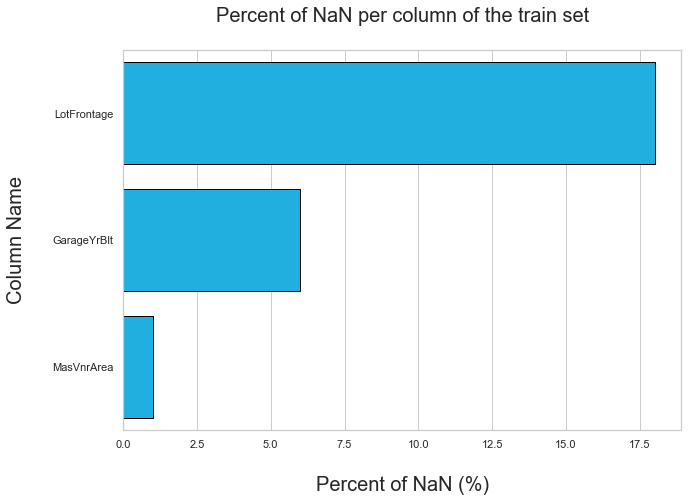

In [19]:
# Get names of columns with missing values (training set)
cols_with_missing = [col for col in data_train_num.columns
                     if data_train_num[col].isnull().any()]

print("Columns with missing (NA) values:")
print(cols_with_missing)

# Count how many NA values are in each of those columns
cols_nan_count = list(map(lambda col: round(data_train_num[col].isna().sum()*100/len(data_train_num)), cols_with_missing))


tab = pd.DataFrame(cols_with_missing, columns=["Column"])
tab["Percent_NaN"] = cols_nan_count
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="deepskyblue")

p.set_title("Percent of NaN per column of the train set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

From the updated numerical features training set, we see that there are three columns with missing values, with "LotFrontage" having around 18% missing values. The missing values from these columns will be imputed where they will be replaced with the median value from each column (which is sensible given that one of the columns is "GarageYrBlt" where the values are strictly discrete, plus they're less affected by outliers).

In [20]:
# Imputation of missing values (NaNs) with SimpleImputer
my_imputer = SimpleImputer(strategy="median")
data_train_imputed = pd.DataFrame(my_imputer.fit_transform(data_train_num))
data_train_imputed.columns = data_train_num.columns

We will also check the distributions to ensure that the distribution of these variables after imputation is not heavily impacted by these changes.

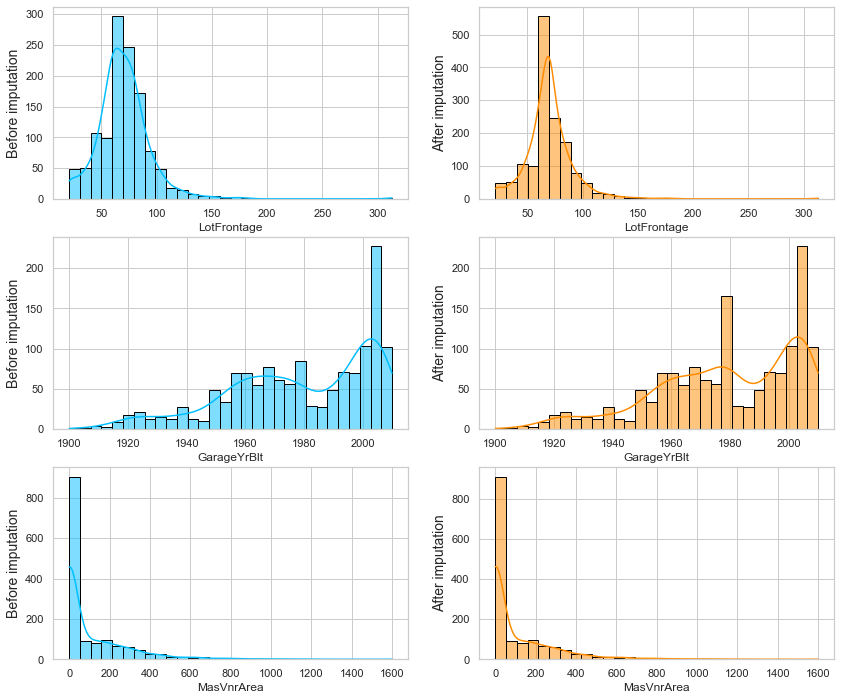

In [21]:
# Check the distribution of each imputed feature before and after imputation

# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "GarageYrBlt", "MasVnrArea"], [0, 1, 2]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=data_train_num[feature],
                     kde=True, bins=30, color="deepskyblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=data_train_imputed[feature],
                     kde=True, bins=30, color="darkorange", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

Looking at the distribution plots, we see that the distributions for "LotFrontage" and "GarageYrBlt" have been changed by imputation (with heavy bias towards the median for "LotFrontage"). Since there is noticeable bias towards the median class for both "LotFrontage" and "GarageYrBlt", these features will be removed from both datasets. The distribution of "MasVnrArea" has not changed that much at all after imputation, and will be kept on.

In [22]:
# Drop 'LotFrontage' and 'GarageYrBlt'
data_train_imputed.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace=True)
data_train_imputed.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageArea,MasVnrArea,BsmtFinSF1,2ndFlrSF,Fireplaces,WoodDeckSF,OpenPorchSF,SalePrice
0,7.00,"2,003.00","2,003.00",856.00,856.00,"1,710.00",2.00,8.00,548.00,196.00,706.00,854.00,0.00,0.00,61.00,"208,500.00"
1,6.00,"1,976.00","1,976.00","1,262.00","1,262.00","1,262.00",2.00,6.00,460.00,0.00,978.00,0.00,1.00,298.00,0.00,"181,500.00"
2,7.00,"2,001.00","2,002.00",920.00,920.00,"1,786.00",2.00,6.00,608.00,162.00,486.00,866.00,1.00,0.00,42.00,"223,500.00"
3,7.00,"1,915.00","1,970.00",756.00,961.00,"1,717.00",1.00,7.00,642.00,0.00,216.00,756.00,1.00,0.00,35.00,"140,000.00"
4,8.00,"2,000.00","2,000.00","1,145.00","1,145.00","2,198.00",2.00,9.00,836.00,350.00,655.00,"1,053.00",1.00,192.00,84.00,"250,000.00"


In [23]:
# Drop these same features from test set
data_test_num.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace=True)

Now we will deal with missing values from the test dataset.

Columns with missing (NA) values:
['TotalBsmtSF', 'GarageArea', 'MasVnrArea', 'BsmtFinSF1']


Text(0, 0.5, 'Column Name\n')

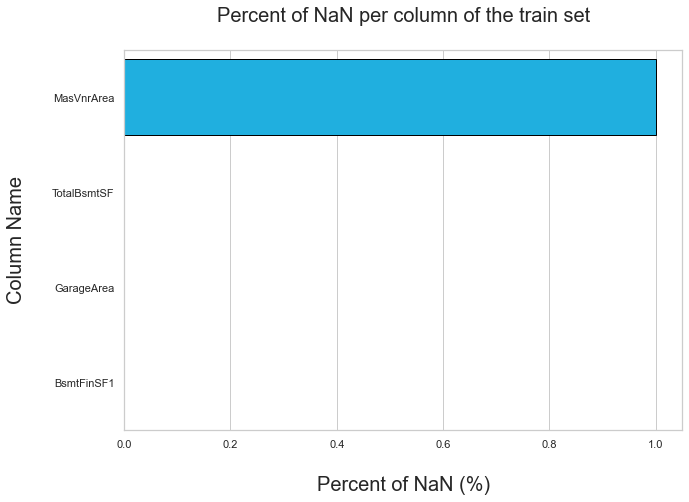

In [24]:
# Get names of columns with missing values (test set)
cols_with_missing_b = [col for col in data_test_num.columns
                       if data_test_num[col].isnull().any()]

print("Columns with missing (NA) values:")
print(cols_with_missing_b)

# Count how many NA values are in each of those columns
cols_nan_count_b = list(map(lambda col: round(data_test_num[col].isna().sum()*100/len(data_test_num)), cols_with_missing_b))


tab = pd.DataFrame(cols_with_missing_b, columns=["Column"])
tab["Percent_NaN"] = cols_nan_count_b
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="deepskyblue")

p.set_title("Percent of NaN per column of the train set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

Here there are 4 feature variables that have missing values, but they all have a very small percentage of missing values. Each of these values will be filled in with the median from each perspective column.

In [25]:
# Imputation of missing values (NaNs) with SimpleImputer
my_imputer = SimpleImputer(strategy="median")
data_test_imputed = pd.DataFrame(my_imputer.fit_transform(data_test_num))
data_test_imputed.columns = data_test_num.columns

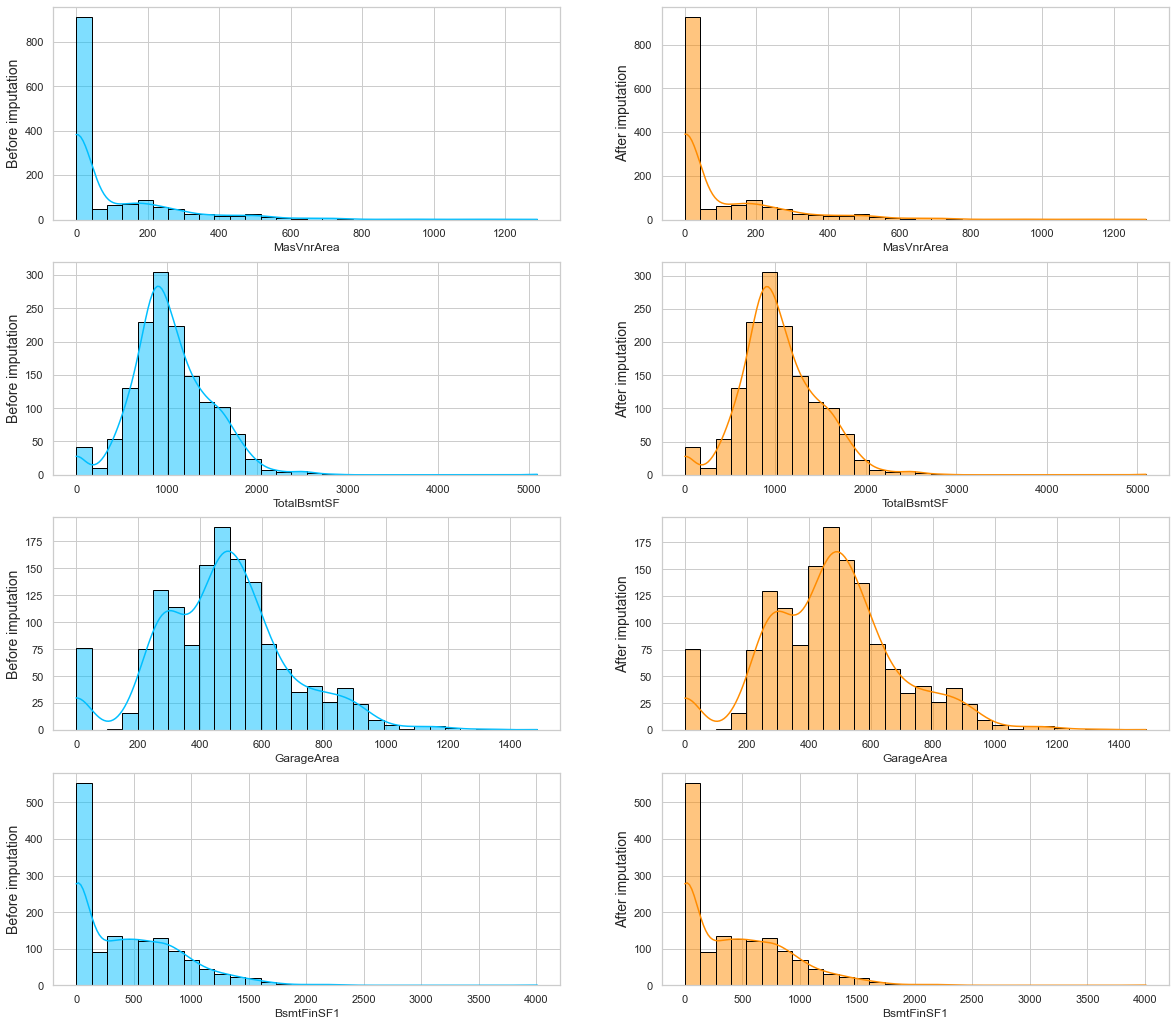

In [26]:
# Check the distribution of each imputed feature before and after imputation

# Define figure parameters
sns.set(rc={"figure.figsize": (20, 18)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(4, 2)

# Plot the results
for feature, fig_pos in zip(tab["Column"].tolist(), range(0, 6)):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=data_test_num[feature],
                     kde=True, bins=30, color="deepskyblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=data_test_imputed[feature],
                     kde=True, bins=30, color="darkorange", edgecolor="black",)
    q.set_ylabel(f"After imputation", fontsize=14)

The distribution of each of these variables before and after imputation does not really change at all, so all of these variables will be kept on. The shape of both datasets consisting of numerical features is shown below.

In [27]:
print(f"Training set shape (Numerical features): {data_train_imputed.shape}\n")
print(f"Test set shape (Numerical features): {data_test_imputed.shape}\n")

Training set shape (Numerical features): (1460, 16)

Test set shape (Numerical features): (1459, 15)



# Categorical Data

Now we focus on the categorical features from each dataset. Firstly we separate the categorical features from both datasets into their own DataFrames data_train_categ and data_test_categ.

In [28]:
# Categorical to Quantitative relationship
categorical_features = [
    i for i in data_train.columns if data_train.dtypes[i] == "object"]
categorical_features.append("SalePrice")

# Train set
data_train_categ = data_train[categorical_features]

# Test set (-1 because test set don't have 'Sale Price')
data_test_categ = data_test[categorical_features[:-1]]

In [29]:
print(f"Training set shape (Categorical features): {data_train_categ.shape}\n")
print(f"Test set shape (Categorical features): {data_test_categ.shape}\n")

Training set shape (Categorical features): (1460, 44)

Test set shape (Categorical features): (1459, 43)



## Distribution

C:\Users\Arjun\AppData\Local\Temp/ipykernel_6096/2993567327.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
C:\Users\Arjun\AppData\Local\Temp/ipykernel_6096/2993567327.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
C:\Users\Arjun\AppData\Local\Temp/ipykernel_6096/2993567327.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
C:\Users\Arjun\AppData\Local\Temp/ipykernel_6096/2993567327.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
C:\Users\Arjun\AppData\Local\Temp/ipykernel_6096/2993567327.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.g

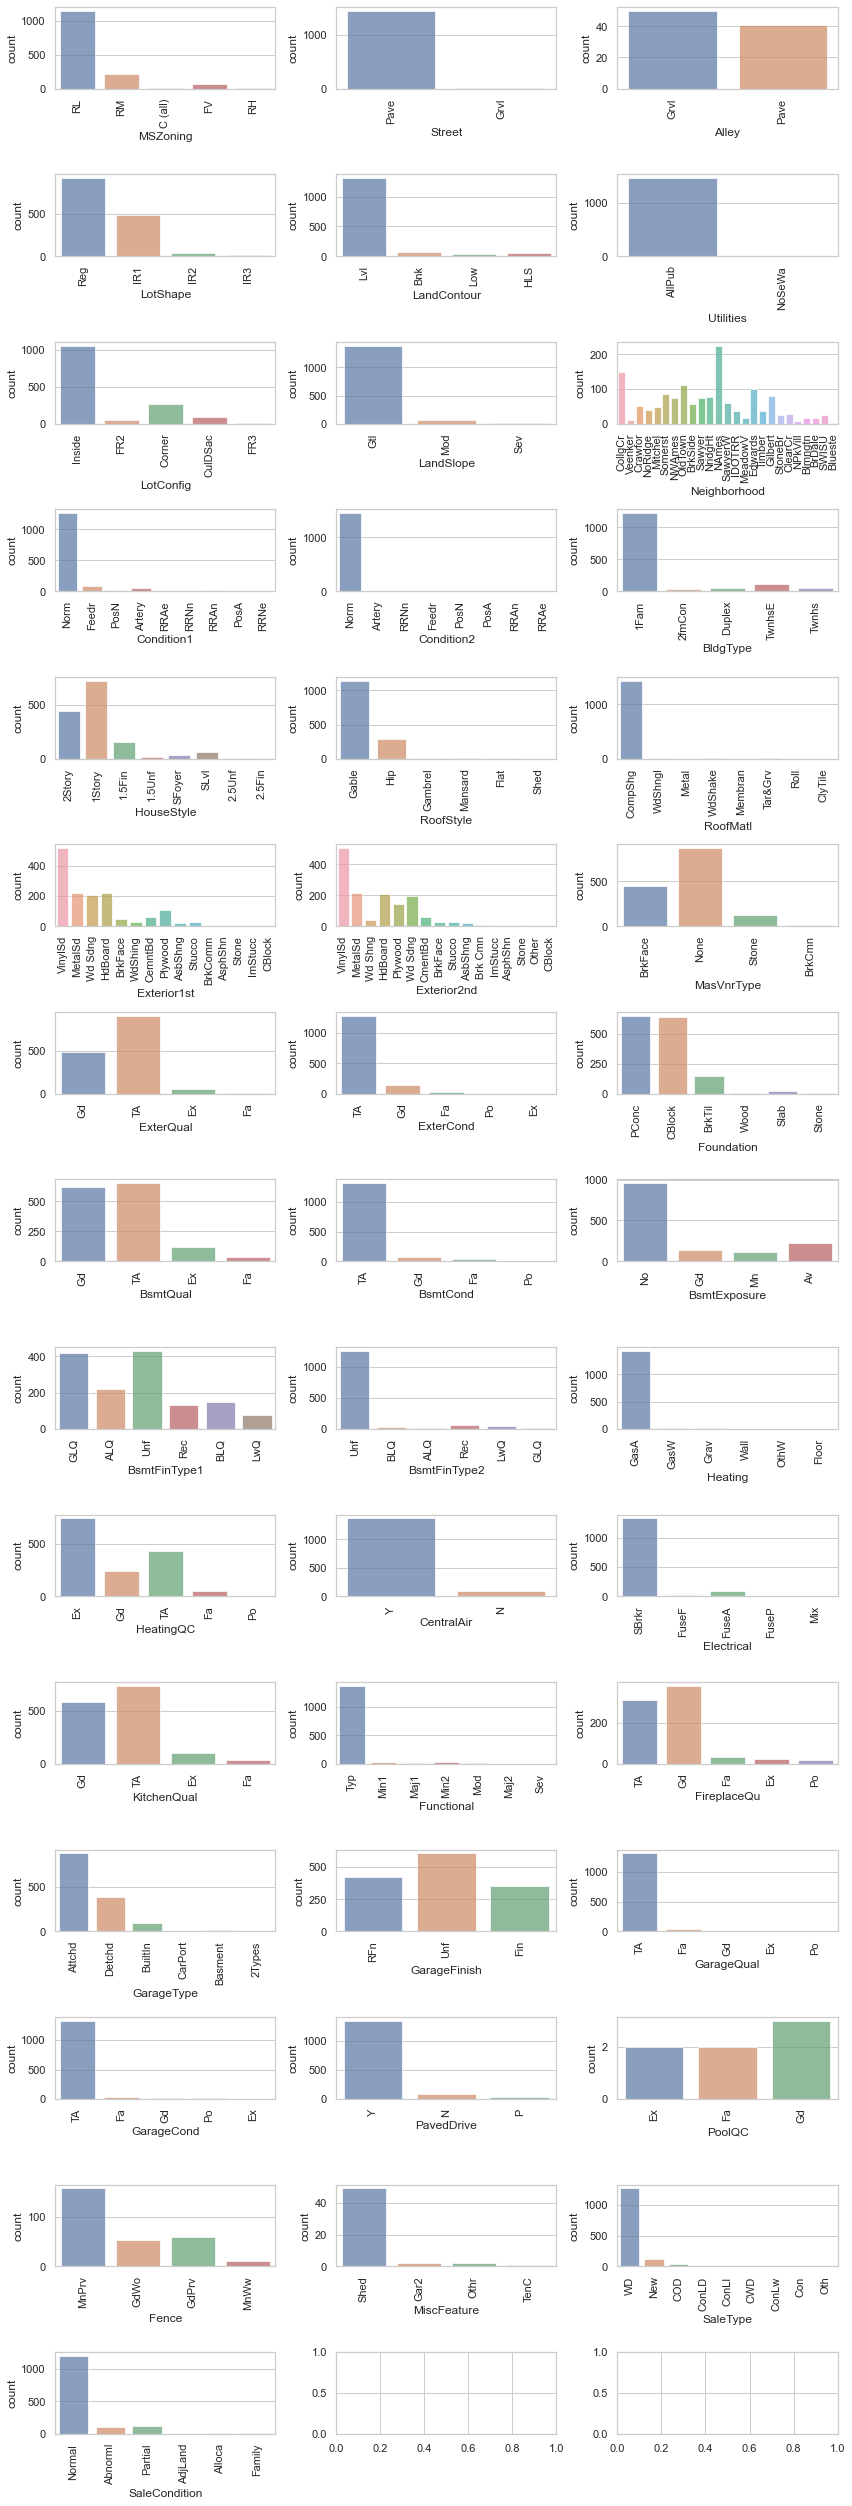

In [30]:
# Countplot for each of the categorical features in the training set
# Determine which categorical features are dominated by one outcome
fig, axes = plt.subplots(round(len(data_train_categ.columns) / 3), 3, figsize=(12, 35))

for i, ax in enumerate(fig.axes):
    # plot barplot of each feature
    if i < len(data_train_categ.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        sns.countplot(x=data_train_categ.columns[i], alpha=0.7, data=data_train_categ, ax=ax)

fig.tight_layout()

Looking at the Count Plots above, we see that some of these variables are highly dominated by one feature. Since those variables will have minimal impact on the final house prices, those variables dominated by one outcome will be removed from both datasets.

In [31]:
cols_to_drop = [
    'Street',
    'LandContour',
    'Utilities',
    'LandSlope',
    'Condition2',
    'RoofMatl',
    'BsmtCond',
    'BsmtFinType2',
    'Heating',
    'CentralAir',
    'Electrical',
    'Functional',
    'GarageQual',
    'GarageCond',
    'PavedDrive'
]

# Training set
data_train_categ.drop(cols_to_drop, axis=1, inplace=True)

# Test set
data_test_categ.drop(cols_to_drop, axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
print(f"Training set shape (Categorical features): {data_train_categ.shape}\n")
print(f"Test set shape (Categorical features): {data_test_categ.shape}\n")

Training set shape (Categorical features): (1460, 29)

Test set shape (Categorical features): (1459, 28)



## Variation of target variable with each categorical feature

C:\Users\Arjun\AppData\Local\Temp/ipykernel_6096/2244012023.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=75)
C:\Users\Arjun\AppData\Local\Temp/ipykernel_6096/2244012023.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=75)
C:\Users\Arjun\AppData\Local\Temp/ipykernel_6096/2244012023.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=75)
C:\Users\Arjun\AppData\Local\Temp/ipykernel_6096/2244012023.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=75)
C:\Users\Arjun\AppData\Local\Temp/ipykernel_6096/2244012023.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.g

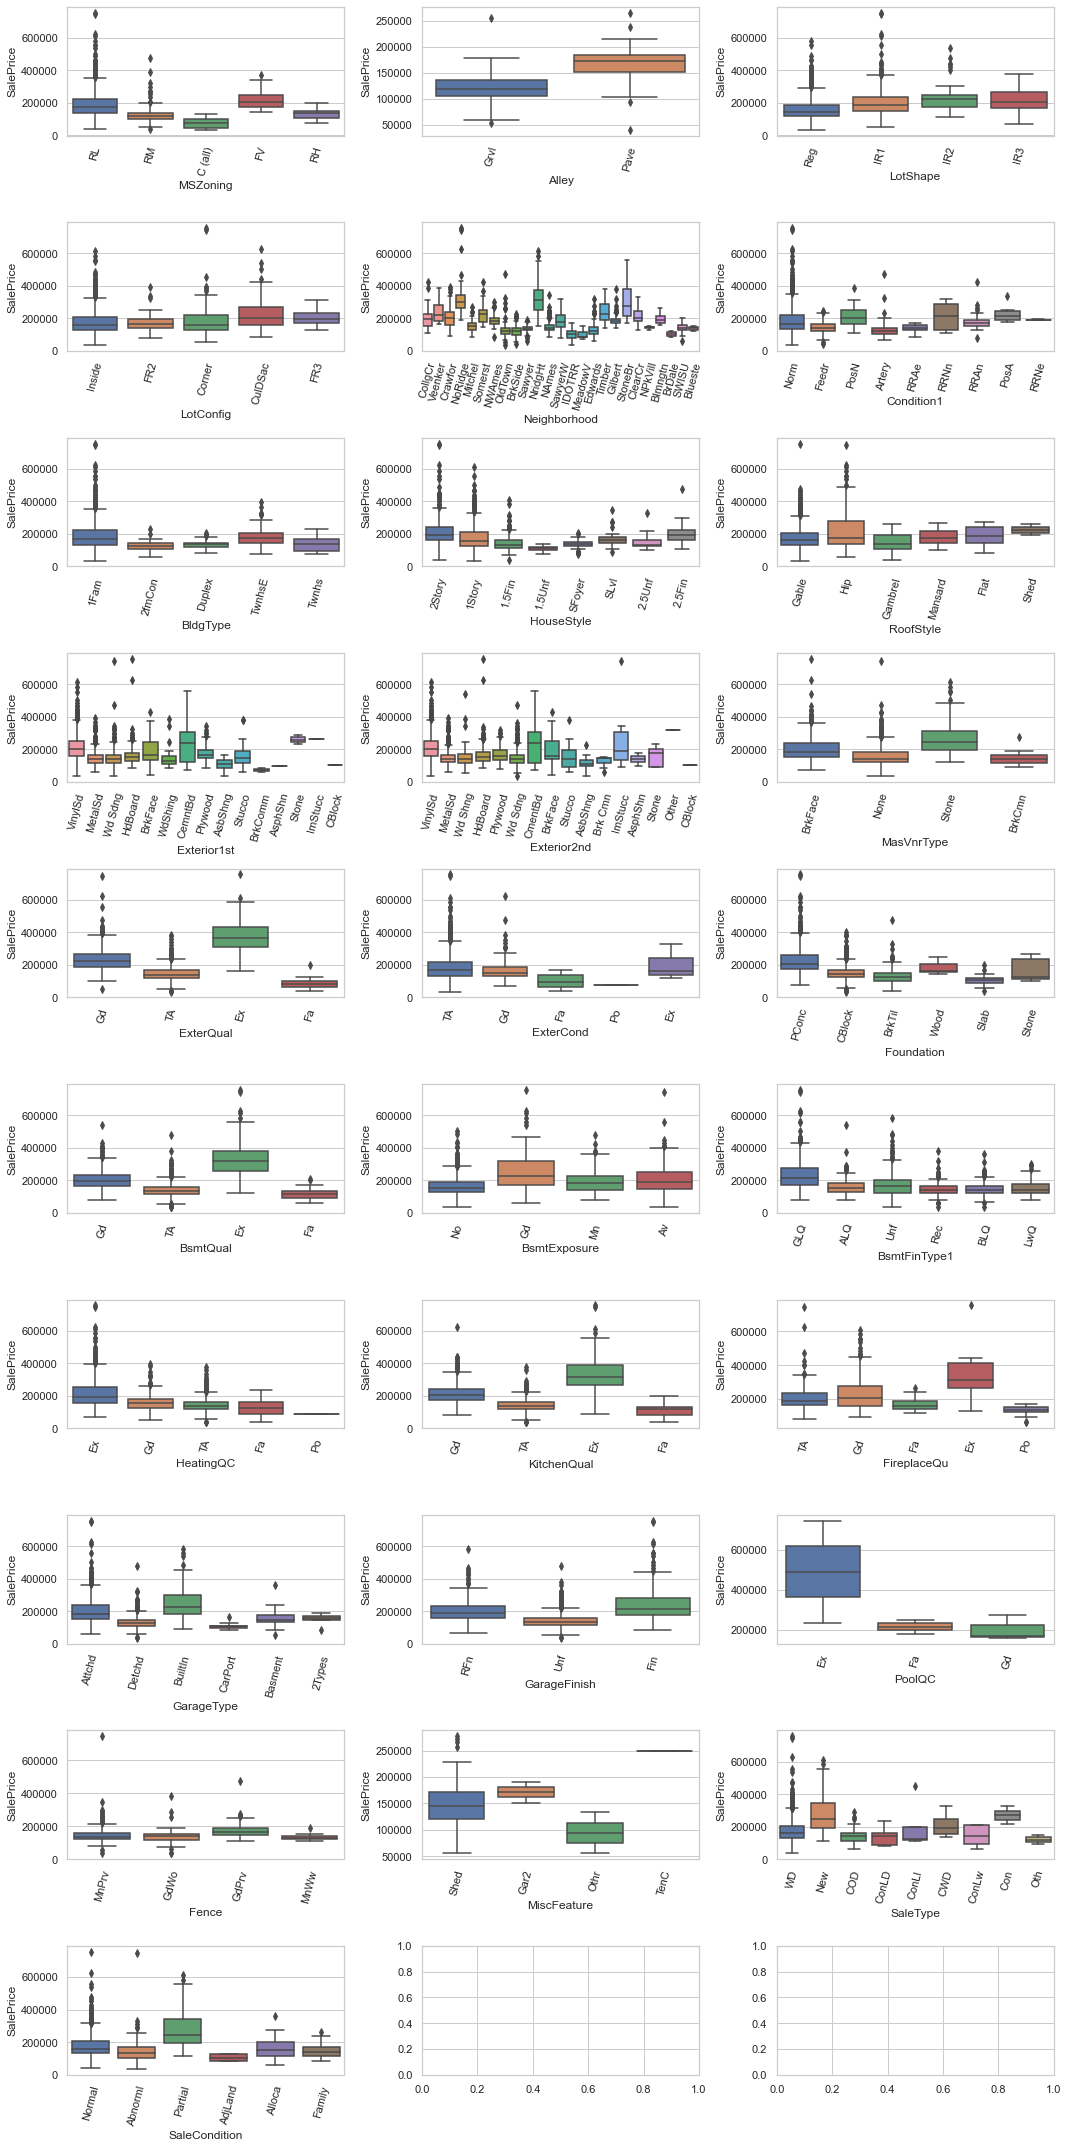

In [33]:
# With the boxplot we can see the variation of the target 'SalePrice' in each of the categorical features
fig, axes = plt.subplots(
    round(len(data_train_categ.columns)/3), 3, figsize=(15, 30))

for i, ax in enumerate(fig.axes):
    # plot the variation of SalePrice in each feature
    if i < len(data_train_categ.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=75)
        sns.boxplot(
            x=data_train_categ.columns[i], y="SalePrice", data=data_train_categ, ax=ax)

fig.tight_layout()

Looking at these box plots, we see that the distribution of sale price for certain categorical variables are similar to each other (like "Exterior1st" and "Exterior2nd") which suggests that certain categorical variables are co-dependent on each other. There are three pairs of categorical variables for which the distribution of sale price is very similar:

* "Exterior1st" and "Exterior2nd"
* "ExterQual" and "MasVnrType"
* "BsmtQual" and "BsmtExposure"

We will perform a Chi-squared test for each pair of variables at a 5% significance level to determine whether or not there is a strong dependency between these variables.

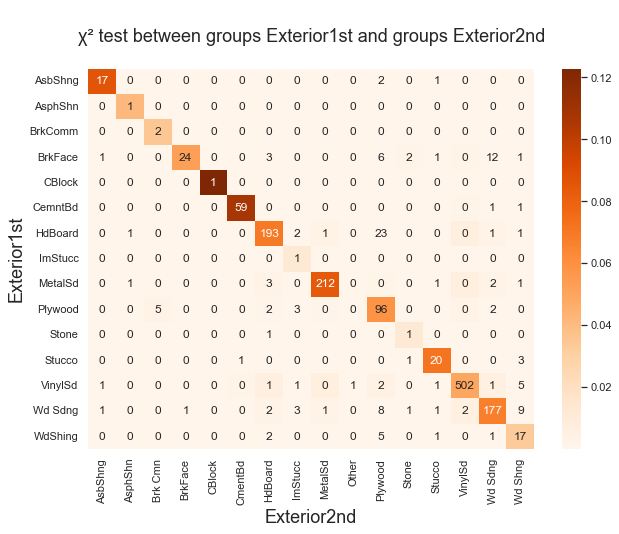

P-Value of the ChiSq Test bewteen Exterior1st and Exterior2nd is: 0.0

significance=0.050, p=0.000
Dependent (reject H0)


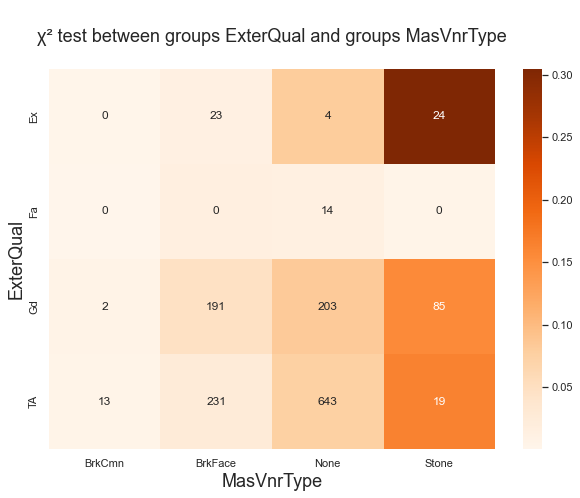

P-Value of the ChiSq Test bewteen ExterQual and MasVnrType is: 1.0187554679218715e-54

significance=0.050, p=0.000
Dependent (reject H0)


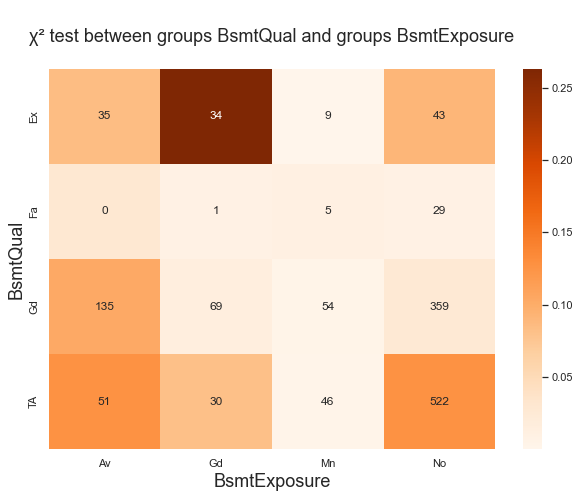

P-Value of the ChiSq Test bewteen BsmtQual and BsmtExposure is: 3.879215036512606e-32

significance=0.050, p=0.000
Dependent (reject H0)


In [34]:
# Plot contingency table

sns.set(rc={"figure.figsize": (10, 7)})

X = ["Exterior1st", "ExterQual", "BsmtQual"]
Y = ["Exterior2nd", "MasVnrType", "BsmtExposure"]

# Parameters for Chi-squared test (5% significance level)
prob = 0.95
alpha = 1.0 - prob

for i, j in zip(X, Y):

    # Contingency table
    cont = data_train_categ[[i, j]].pivot_table(
        index=i, columns=j, aggfunc=len, margins=True, margins_name="Total")
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n = len(data_train_categ)
    indep = tx.dot(ty) / n
    c = cont.fillna(0)  # Replace NaN with 0 in the contingency table
    measure = (c - indep) ** 2 / indep
    xi_n = measure.sum().sum()
    table = measure / xi_n

    # Plot contingency table
    p = sns.heatmap(table.iloc[:-1, :-1],
                    annot=c.iloc[:-1, :-1], fmt=".0f", cmap="Oranges")
    p.set_xlabel(j, fontsize=18)
    p.set_ylabel(i, fontsize=18)
    p.set_title(f"\nχ² test between groups {i} and groups {j}\n", size=18)
    plt.show()

    # Performing Chi-sq test
    CrosstabResult = pd.crosstab(
        index=data_train_categ[i], columns=data_train_categ[j])
    ChiSqResult = chi2_contingency(CrosstabResult)
    # P-Value is the Probability of H0 being True
    print(f"P-Value of the ChiSq Test bewteen {i} and {j} is: {ChiSqResult[1]}\n")
    print('significance=%.3f, p=%.3f' % (alpha, ChiSqResult[1]))
    if ChiSqResult[1] <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

Here, the contigency tables for each pair of categorical variables considered is printed as a heatmap, with the colours representing the relative error between the actual value of the table with its expected value. After performing the Chi-squared test for each pairs of variables considered, we see that there is strong co-dependency for each of these variables. Since highly dependent/correlated variables do not add much relevant new information with regards to the value of the target variable, we will drop one of each co-dependent variable from the dataset.

In [35]:
# Drop the one of each co-dependent variables
# Training set
data_train_categ.drop(Y, axis=1, inplace=True)

# Test set
data_test_categ.drop(Y, axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [36]:
print(f"Training set shape (Categorical features): {data_train_categ.shape}\n")
print(f"Test set shape (Categorical features): {data_test_categ.shape}\n")

Training set shape (Categorical features): (1460, 26)

Test set shape (Categorical features): (1459, 25)



## Missing Values

Categorical Columns with missing (NA) values:
['Alley', 'BsmtQual', 'BsmtFinType1', 'FireplaceQu', 'GarageType', 'GarageFinish', 'PoolQC', 'Fence', 'MiscFeature']


Text(0, 0.5, 'Column Name\n')

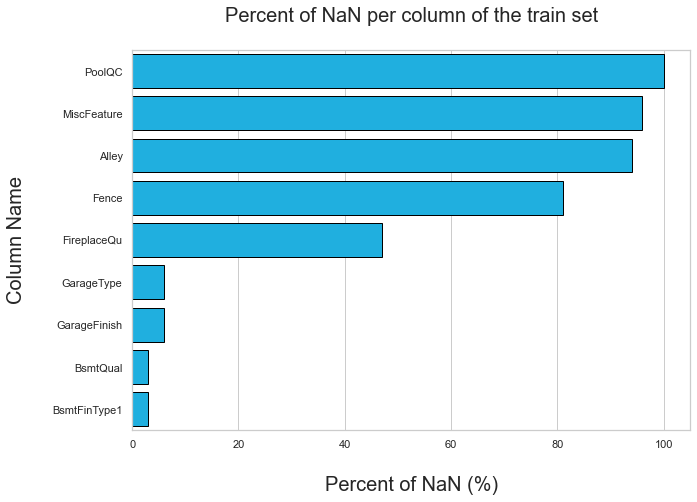

In [37]:
# Get names of categorical columns with missing values (training set)
cat_cols_with_missing = [col for col in data_train_categ.columns
                         if data_train_categ[col].isnull().any()]

print("Categorical Columns with missing (NA) values:")
print(cat_cols_with_missing)

# Count how many NA values are in each of those columns
cat_cols_nan_count = list(map(lambda col: round(data_train_categ[col].isna().sum()*100/len(data_train_categ)), 
                              cat_cols_with_missing))


tab_cat = pd.DataFrame(cat_cols_with_missing, columns=["Column"])
tab_cat["Percent_NaN"] = cat_cols_nan_count
tab_cat.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab_cat,
                edgecolor="black", color="deepskyblue")

p.set_title("Percent of NaN per column of the train set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

In the training set, there are five categorical variables that have a significant amount of missing values. To help reduce the error, we will remove any columns with more than 30% NaN entries from both datasets. Imputation will be used to fill in the missing entries from the remaining columns in the training set using the modal class.

In [38]:
# Drop categorical columns that have at least 30% missing values
large_na = [col for col in cat_cols_with_missing if (data_train_categ[col].isna().sum()/data_train_categ.shape[0]) > 0.3]

print("Columns to be dropped:")
print(large_na)

data_train_categ.drop(large_na, axis=1, inplace=True)

Columns to be dropped:
['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [39]:
# Fill the NaN of each feature by the corresponding modal class
categ_fill_null = {"GarageType": data_train_categ["GarageType"].mode().iloc[0],
                   "GarageFinish": data_train_categ["GarageFinish"].mode().iloc[0],
                   "BsmtQual": data_train_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": data_train_categ["BsmtFinType1"].mode().iloc[0]}

data_train_categ = data_train_categ.fillna(value=categ_fill_null)

After dropping those same columns from the test dataset, we investigate the categorical variables from that dataset that have missing values.

Categorical Columns with missing (NA) values:
['MSZoning', 'Exterior1st', 'BsmtQual', 'BsmtFinType1', 'KitchenQual', 'GarageType', 'GarageFinish', 'SaleType']


Text(0, 0.5, 'Column Name\n')

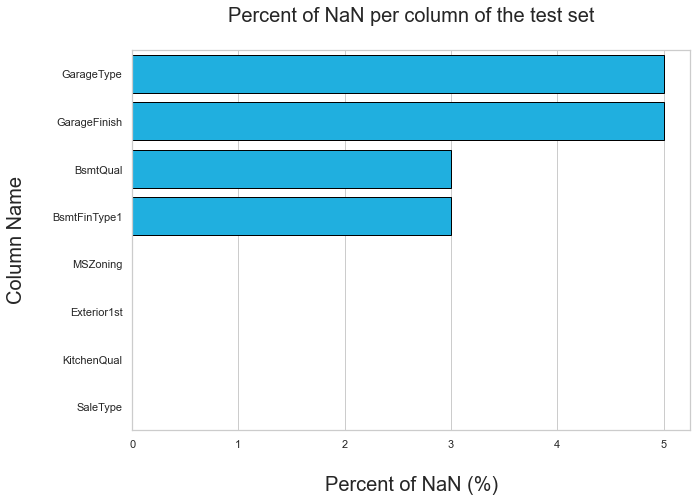

In [40]:
# Drop the same categorical columns from the test set
data_test_categ.drop(large_na, axis=1, inplace=True)

# Get names of categorical columns with missing values (test set)
cat_cols_with_missing_t = [col for col in data_test_categ.columns
                           if data_test_categ[col].isnull().any()]

print("Categorical Columns with missing (NA) values:")
print(cat_cols_with_missing_t)

# Count how many NA values are in each of those columns
cat_cols_nan_count_t = list(map(lambda col: round(data_test_categ[col].isna().sum()*100/len(data_test_categ)), 
                              cat_cols_with_missing_t))


tab_cat_t = pd.DataFrame(cat_cols_with_missing_t, columns=["Column"])
tab_cat_t["Percent_NaN"] = cat_cols_nan_count_t
tab_cat_t.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab_cat_t,
                edgecolor="black", color="deepskyblue")

p.set_title("Percent of NaN per column of the test set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

There are a few more columns in the test dataset that have missing values, but none of them have more than 5% missing values. Therefore, we will fill in each NaN entry for each feature using it's corresponding modal class like before.

In [41]:
# Fill the NaN of each feature by the corresponding modal class
categ_fill_null = {"GarageType": data_test_categ["GarageType"].mode().iloc[0],
                   "GarageFinish": data_test_categ["GarageFinish"].mode().iloc[0],
                   "BsmtQual": data_test_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": data_test_categ["BsmtFinType1"].mode().iloc[0],
                   "MSZoning": data_test_categ["MSZoning"].mode().iloc[0],
                   "Exterior1st": data_test_categ["Exterior1st"].mode().iloc[0],
                   "KitchenQual": data_test_categ["KitchenQual"].mode().iloc[0],
                   "SaleType": data_test_categ["SaleType"].mode().iloc[0]}

data_test_categ = data_test_categ.fillna(value=categ_fill_null)

The shape of each dataset (containing categorical features only) after imputation is shown below.

In [42]:
print(f"Training set shape (Categorical features): {data_train_categ.shape}\n")
print(f"Test set shape (Categorical features): {data_test_categ.shape}\n")

Training set shape (Categorical features): (1460, 21)

Test set shape (Categorical features): (1459, 20)



## Transformation into numerical values (get_dummies())

Before we combine the categorical data back with the numerical data, we need to transform the categorical entries into numerical entries. This will be done using the get_dummies() function where each categorical feature will be transformed into a binary feature.

In [43]:
# Drop the SalePrice column from the training dataset
data_train_categ.drop(["SalePrice"], axis = 1, inplace = True)

# Use get_dummies to transform the Categorical features into Binary features (Training dataset)
data_train_dummies = pd.get_dummies(data_train_categ)
data_train_dummies.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [44]:
# Apply get_dummies to the test dataset as well
data_test_dummies = pd.get_dummies(data_test_categ)
data_test_dummies.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


From the first few rows of each modified dataset we see that they do not have the same number of columns. We need to check which columns are missing from the test dataset.

In [45]:
# Check if the column headings are the same in both data sets: data_train_dummies and data_test_dummies
dif_1 = [x for x in data_train_dummies.columns if x not in data_test_dummies.columns]
print(f"Features present in df_train_categ and absent in df_test_categ: {dif_1}\n")

dif_2 = [x for x in data_test_dummies.columns if x not in data_test_dummies.columns]
print(f"Features present in df_test_categ set and absent in df_train_categ: {dif_2}")

Features present in df_train_categ and absent in df_test_categ: ['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone']

Features present in df_test_categ set and absent in df_train_categ: []


Three of these columns from the training dataset are not present in the test dataset. Thus they will be dropped from the training dataset to ensure that both datasets have exactly the same features.

In [46]:
# Drop the columns listed in dif_1 from data_train_dummies
data_train_dummies.drop(dif_1, axis=1, inplace=True)

# Check again if the column headings are the same in both data sets: data_train_dummies and data_test_dummies
dif_1 = [x for x in data_train_dummies.columns if x not in data_test_dummies.columns]
print(f"Features present in df_train_categ and absent in df_test_categ: {dif_1}\n")

dif_2 = [x for x in data_test_dummies.columns if x not in data_test_dummies.columns]
print(f"Features present in df_test_categ set and absent in df_train_categ: {dif_2}")

Features present in df_train_categ and absent in df_test_categ: []

Features present in df_test_categ set and absent in df_train_categ: []


The shape of both datasets (categorical features only) after all of these changes are given below.

In [47]:
print(f"Training set shape (Categorical features): {data_train_dummies.shape}\n")
print(f"Test set shape (Categorical features): {data_test_dummies.shape}\n")

Training set shape (Categorical features): (1460, 137)

Test set shape (Categorical features): (1459, 137)



# Preparing Data for modelling

In [48]:
# Join numerical and categorical datasets together
# Training set
data_train_new = pd.concat([data_train_imputed, data_train_dummies], axis = 1)
print(f"Train set: {data_train_new.shape}")

# Test set
data_test_new = pd.concat([data_test_imputed, data_test_dummies], axis = 1)
print(f"Test set: {data_test_new.shape}")

Train set: (1460, 153)
Test set: (1459, 152)


## Further Feature Engineering

The Year of construction and the Year of Remodelling variables will be transformed into new variables representing the Age of the House and the Age since the house was remodelled - this will enable us to apply a log transform to normalize those variables. After the transformation, the variables "YearBuilt" and "YearRemodAdd" will be removed.

In [49]:
# Convert Year of construction to the Age of the house since the construction
data_train_new["AgeSinceConst"] = (data_train_new["YearBuilt"].max() - data_train_new["YearBuilt"])

data_test_new["AgeSinceConst"] = (data_test_new["YearBuilt"].max() - data_test_new["YearBuilt"])

# Drop "YearBuilt"
data_train_new.drop(["YearBuilt"], axis=1, inplace=True)
data_test_new.drop(["YearBuilt"], axis=1, inplace=True)

In [50]:
# Convert Year of remodeling to the Age of the house since the remodeling
data_train_new["AgeSinceRemod"] = (data_train_new["YearRemodAdd"].max() - data_train_new["YearRemodAdd"])

data_test_new["AgeSinceRemod"] = (data_test_new["YearRemodAdd"].max() - data_test_new["YearRemodAdd"])

# Drop "YearRemodAdd"
data_train_new.drop(["YearRemodAdd"], axis=1, inplace=True)
data_test_new.drop(["YearRemodAdd"], axis=1, inplace=True)

Now, we consider the continuous numerical variables that are skewed. A Log transformation will be applied to the skewed numerical variables to help mitigate the strong variation of some variables, and to reduce redundancy. The continuous features are defined below.

In [51]:
continuous_features = ['AgeSinceConst', 'AgeSinceRemod', 'MasVnrArea', 'BsmtFinSF1',
                      'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea',
                      'WoodDeckSF', 'OpenPorchSF']

To obtain the skewed features, we take out variables that are more than 50% skewed.

In [52]:
data_skew_verify = data_train_new.loc[:, continuous_features]

# Select features with absolute Skew higher than 0.5
skew_ft = []

for i in continuous_features:
    # list of skew for each corresponding feature
    skew_ft.append(abs(data_skew_verify[i].skew()))

data_skewed = pd.DataFrame({"Columns": continuous_features, "Abs_Skew": skew_ft})

sk_features = data_skewed[data_skewed["Abs_Skew"] > 0.5]["Columns"].tolist()
print(f"List of skewed features: {sk_features}")

List of skewed features: ['AgeSinceConst', 'AgeSinceRemod', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF']


A log transformation is then applied to the skewed features listed above.

In [53]:
# Log transformation of the skewed features
for i in sk_features:
    # loop over i (features) to calculate Log of surfaces
    # Training set
    data_train_new[i] = np.log((data_train_new[i])+1)
    
    # Test set
    data_test_new[i] = np.log((data_test_new[i])+1)

Looking at the distribution of the numerical features near the start, we noticed that "SalePrice" is skewed as well. To help normalize this variable, a log transformation will be applied to "SalePrice" as well.

In [54]:
# Log transformation of the target variable "SalePrice"
data_train_new["SalePriceLog"] = np.log(data_train_new.SalePrice)

# Drop the original SalePrice
data_train_new.drop(["SalePrice"], axis=1, inplace=True)

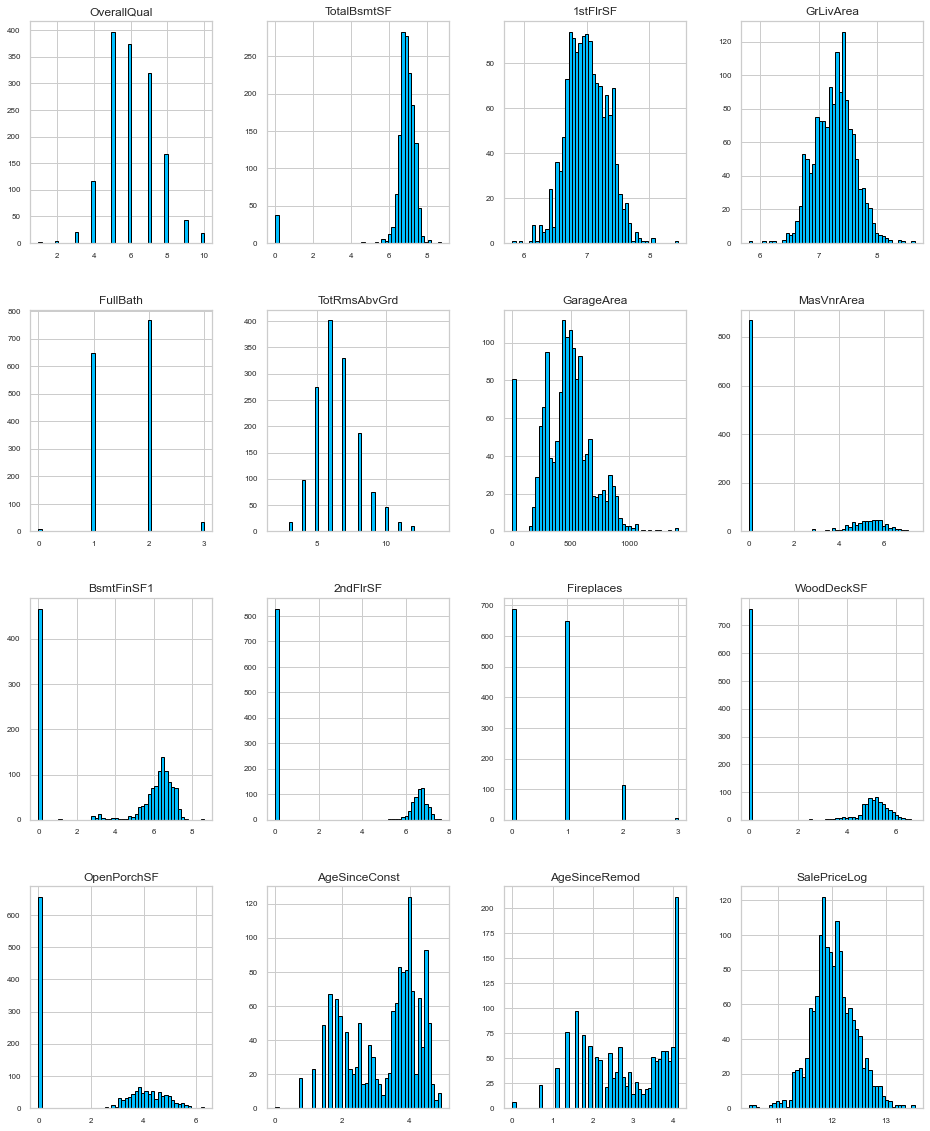

In [55]:
numerical_cols_new = [cname for cname in data_train_new.columns if 
                      data_train_new[cname].dtype in ['int64', 'float64']]

data_train_new_num = data_train_new[numerical_cols_new].copy()

# Plot the distribution of all the numerical features
fig_ = data_train_new_num.hist(figsize=(16, 20), bins=50, color="deepskyblue",
                               edgecolor="black", xlabelsize=8, ylabelsize=8)

Looking at the distribution of the numerical features, we notice that most of the previously skewed variables have a more normal distribution (excluding zero values) with exception of the Age variables, which should result in better predictons.

## Splitting the data into training and test sets

In [56]:
# TRAINING DATASET
# Feature variables
X = data_train_new.copy().drop(["SalePriceLog"], axis = 1)

# Target Variable
y = data_train_new.loc[:, "SalePriceLog"]

print(X.shape)
print(y.shape)

(1460, 152)
(1460,)


In [57]:
# Split the data into Training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

X_train:(1168, 152)
y_train:(1168,)

X_test:(292, 152)
y_test:(292,)


# Modelling

For this project, six supervised learning models will be considered:

* Linear Regression
* Ridge Regression
* Lasso Regression
* Decision Tree Regressor
* Random Forest Regressor
* XGBoost Regressor

To measure model performance and their predicitons the RMSE and R^{2} scores will be used, and 5-fold cross-validation will also be used.

In [58]:
# Define models
model_lin = LinearRegression()
model_ridge = Ridge(alpha = 0.001)
model_lasso = Lasso(alpha = 0.001)
model_tree = DecisionTreeRegressor()
model_ran = RandomForestRegressor()
model_xg = XGBRegressor()

In [59]:
from sklearn.metrics import mean_squared_error, r2_score

# Define a function for each metric
# R²
def rsqr_score(test, pred):
    """Calculate R squared score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        R squared score 
    """
    r2_ = r2_score(test, pred)
    return r2_


# RMSE
def rmse_score(test, pred):
    """Calculate Root Mean Square Error score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Root Mean Square Error score
    """
    rmse_ = np.sqrt(mean_squared_error(test, pred))
    return rmse_


# Print the scores
def print_score(test, pred, model):
    """Print calculated score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        print the regressor name
        print the R squared score
        print Root Mean Square Error score
    """

    print(f"- Regressor: {model}")
    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}\n")

## Linear Regression

In [60]:
scores_lin = -1 * cross_val_score(model_lin, X_train, y_train,
                                  cv=5,
                                  scoring='neg_mean_squared_error')

print("MSE scores (Linear Model):\n", scores_lin)
print("Mean MSE scores:", scores_lin.mean())

MSE scores (Linear Model):
 [0.01926515 0.01996788 0.03356139 0.02016179 0.01592235]
Mean MSE scores: 0.02177571380458774


In [61]:
model_lin.fit(X_train, y_train)
y_pred_lin = model_lin.predict(X_test)
print_score(y_test, y_pred_lin, "Linear")

- Regressor: Linear
R²: 0.9060237179529058
RMSE: 0.13242826218245382



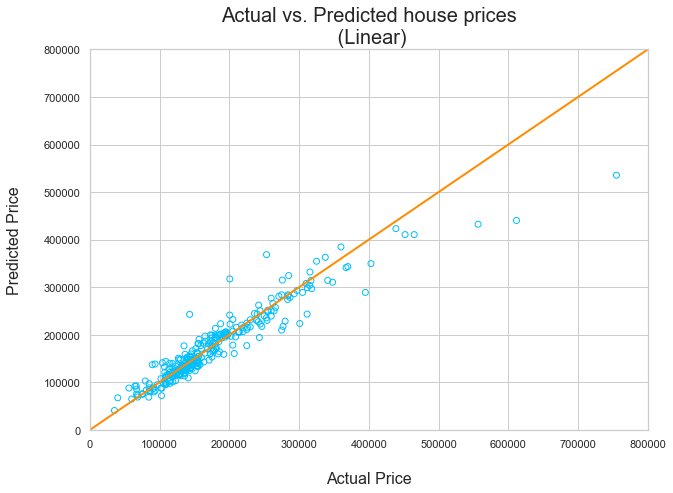

In [62]:
plt.figure()
plt.title("Actual vs. Predicted house prices\n (Linear)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_lin),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

## Ridge Regression

In [63]:
scores_ridge = -1 * cross_val_score(model_ridge, X_train, y_train,
                                  cv=5,
                                  scoring='neg_mean_squared_error')

print("MSE scores (Ridge Model):\n", scores_ridge)
print("Mean MSE scores:", scores_ridge.mean())

MSE scores (Ridge Model):
 [0.0192634  0.01996686 0.03355863 0.02016031 0.01591726]
Mean MSE scores: 0.0217732911790542


In [64]:
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)
print_score(y_test, y_pred_ridge, "Ridge")

- Regressor: Ridge
R²: 0.9060323368126849
RMSE: 0.1324221893374296



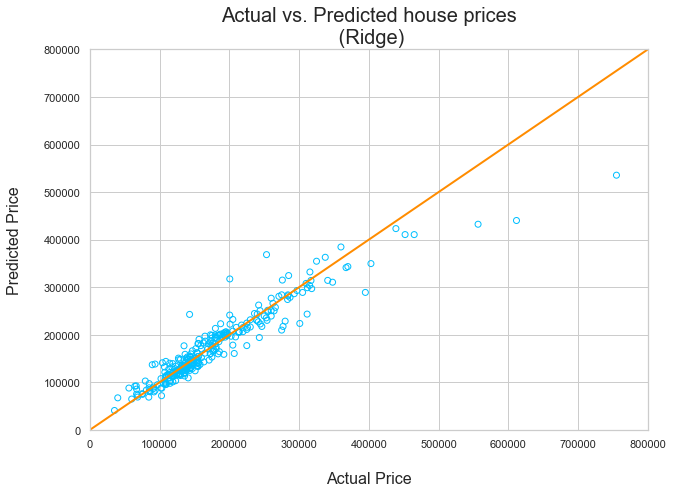

In [65]:
plt.figure()
plt.title("Actual vs. Predicted house prices\n (Ridge)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_ridge),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

### Hyperparamter Tuning (Ridge)

In [66]:
# Define hyperparameters
alphas = np.linspace(0, 10, 100).tolist()

tuned_parameters = {"alpha": alphas}

# GridSearch
ridge_cv = GridSearchCV(Ridge(), tuned_parameters, cv=10, n_jobs=-1, verbose=1)

# fit the GridSearch on train set
ridge_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {ridge_cv.best_params_}")
print(f"Best R² (train): {ridge_cv.best_score_}")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best hyperparameters: {'alpha': 7.575757575757575}
Best R² (train): 0.8685802852487582


In [67]:
model_ridge_opt = Ridge(alpha = ridge_cv.best_params_["alpha"])
model_ridge_opt.fit(X_train, y_train)
y_pred_ridge_opt = model_ridge_opt.predict(X_test)
print_score(y_test, y_pred_ridge_opt, "Ridge")

- Regressor: Ridge
R²: 0.9062192216136495
RMSE: 0.13229044182669816



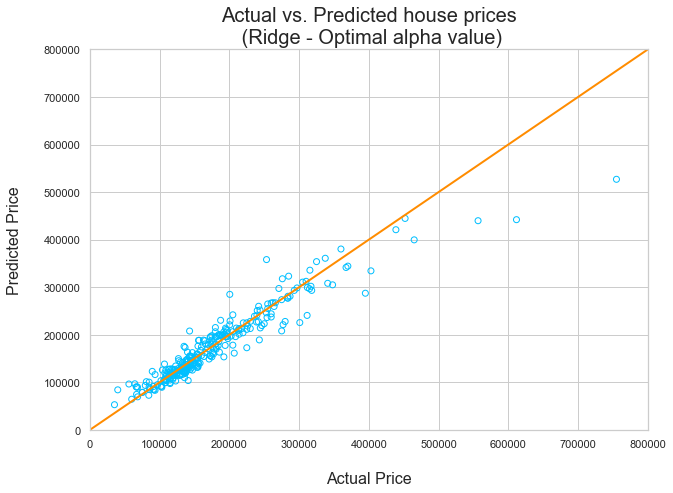

In [68]:
plt.figure()
plt.title("Actual vs. Predicted house prices\n (Ridge - Optimal alpha value)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_ridge_opt),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

## Lasso Regression

In [69]:
scores_lasso = -1 * cross_val_score(model_lasso, X_train, y_train,
                                  cv=5,
                                  scoring='neg_mean_squared_error')

print("MSE scores (Lasso Model):\n", scores_lasso)
print("Mean MSE scores:", scores_lasso.mean())

MSE scores (Lasso Model):
 [0.01771706 0.02081564 0.03172244 0.01652713 0.0141346 ]
Mean MSE scores: 0.02018337395113655


In [70]:
model_lasso.fit(X_train, y_train)
y_pred_lasso = model_lasso.predict(X_test)
print_score(y_test, y_pred_lasso, "Lasso")

- Regressor: Lasso
R²: 0.8957374770295495
RMSE: 0.13948762035721204



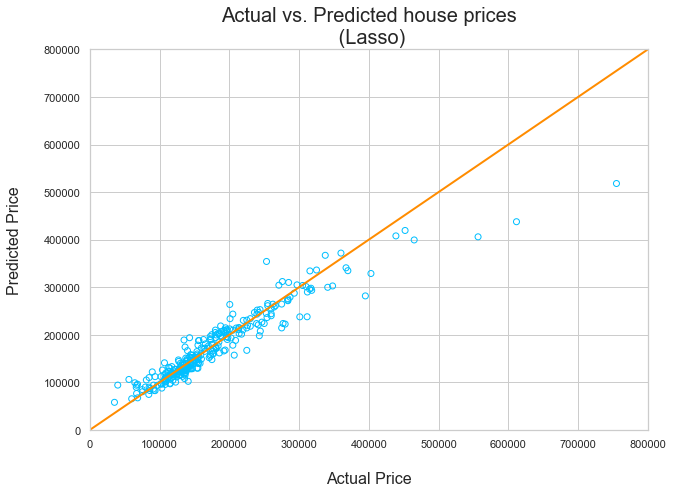

In [71]:
plt.figure()
plt.title("Actual vs. Predicted house prices\n (Lasso)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_lasso),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

### Hyperparameter Tuning (Lasso)

In [72]:
# Define hyperparameters
alphas = np.logspace(-5, 5, 100).tolist()

tuned_parameters = {"alpha": alphas}

# GridSearch
lasso_cv = GridSearchCV(Lasso(), tuned_parameters, cv=10, n_jobs=-1, verbose=1)

# fit the GridSearch on train set
lasso_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {lasso_cv.best_params_}")
print(f"Best R² (train): {lasso_cv.best_score_}")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best hyperparameters: {'alpha': 0.0005214008287999684}
Best R² (train): 0.8701659563829791


In [73]:
model_lasso_opt = Lasso(alpha = lasso_cv.best_params_["alpha"])

model_lasso_opt.fit(X_train, y_train)
y_pred_lasso_opt = model_lasso_opt.predict(X_test)
print_score(y_test, y_pred_lasso_opt, "Lasso")

- Regressor: Lasso
R²: 0.907306130597721
RMSE: 0.13152159172231062



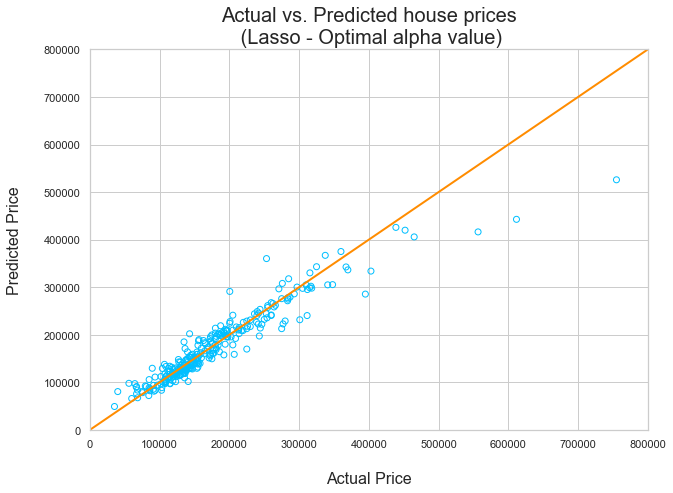

In [74]:
plt.figure()
plt.title("Actual vs. Predicted house prices\n (Lasso - Optimal alpha value)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_lasso_opt),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

## Decision Tree Regressor

In [75]:
scores_tree = -1 * cross_val_score(model_tree, X_train, y_train,
                                   cv=5,
                                   scoring='neg_mean_squared_error')

print("MSE scores (Decision Tree Model):\n", scores_tree)
print("Mean MSE scores:", scores_tree.mean())

MSE scores (Decision Tree Model):
 [0.05497138 0.0546527  0.04845354 0.04372406 0.03972551]
Mean MSE scores: 0.048305438830354416


In [76]:
model_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)
print_score(y_test, y_pred_tree, "Decision Tree")

- Regressor: Decision Tree
R²: 0.7930510526636985
RMSE: 0.19651837359424065



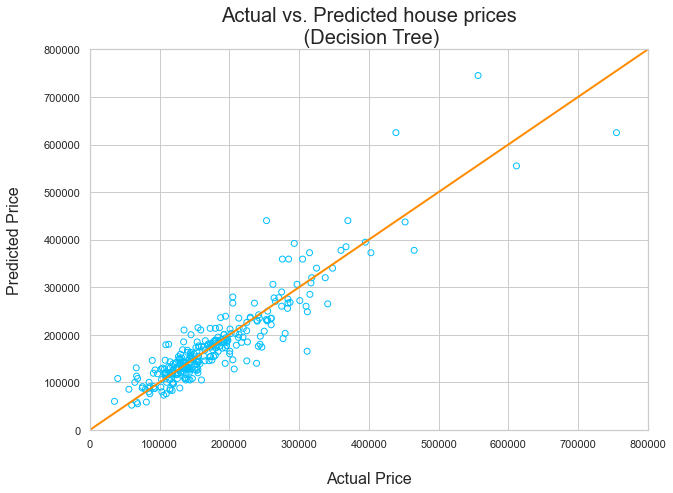

In [77]:
plt.figure()
plt.title("Actual vs. Predicted house prices\n (Decision Tree)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_tree),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

## Random Forest Regressor

In [78]:
scores_ran = -1 * cross_val_score(model_ran, X_train, y_train,
                                  cv=5,
                                  scoring='neg_mean_squared_error')

print("MSE scores (Random Forest Model):\n", scores_ran)
print("Mean MSE scores:", scores_ran.mean())

MSE scores (Random Forest Model):
 [0.01798144 0.02651911 0.03047696 0.02142803 0.01555583]
Mean MSE scores: 0.022392275416112297


In [79]:
model_ran.fit(X_train, y_train)
y_pred_ran = model_ran.predict(X_test)
print_score(y_test, y_pred_ran, "Random Forest")

- Regressor: Random Forest
R²: 0.8771812769440811
RMSE: 0.15139231822050572



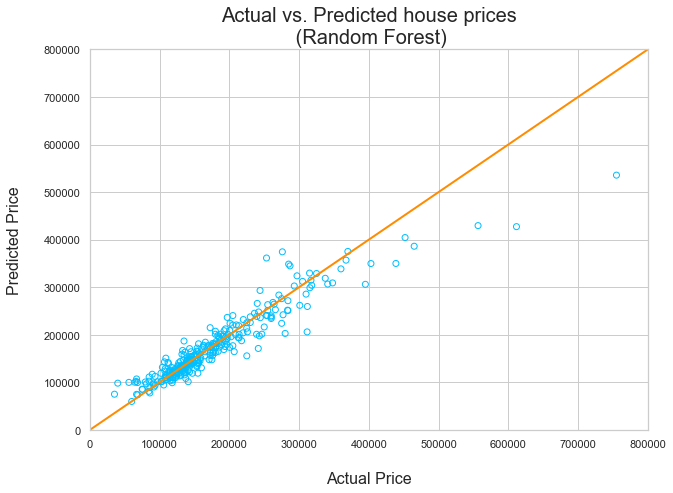

In [80]:
plt.figure()
plt.title("Actual vs. Predicted house prices\n (Random Forest)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_ran),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

## XGBoost Regression

In [81]:
# Define hyperparameters
tuned_parameters_xgb = {"max_depth": [3],
                        "colsample_bytree": [0.3, 0.7],
                        "learning_rate": [0.01, 0.05, 0.1],
                        "n_estimators": [100, 500, 1000]}

# GridSearch
xgbr_cv = GridSearchCV(estimator=XGBRegressor(),
                       param_grid=tuned_parameters_xgb,
                       cv=5,
                       n_jobs=-1,
                       verbose=1)

# fit the GridSearch on train set
xgbr_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {xgbr_cv.best_params_}\n")
print(f"Best R²: {xgbr_cv.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}

Best R²: 0.8800435347744271


In [82]:
model_xgb_opt = XGBRegressor(colsample_bytree = xgbr_cv.best_params_["colsample_bytree"],
                             learning_rate = xgbr_cv.best_params_["learning_rate"],
                             max_depth = xgbr_cv.best_params_["max_depth"],
                             n_estimators = xgbr_cv.best_params_["n_estimators"])

model_xgb_opt.fit(X_train, y_train)
y_pred_xgb_opt = model_xgb_opt.predict(X_test)
print_score(y_test, y_pred_xgb_opt, "XGBoost")

- Regressor: XGBoost
R²: 0.8964221771875893
RMSE: 0.13902885285968886



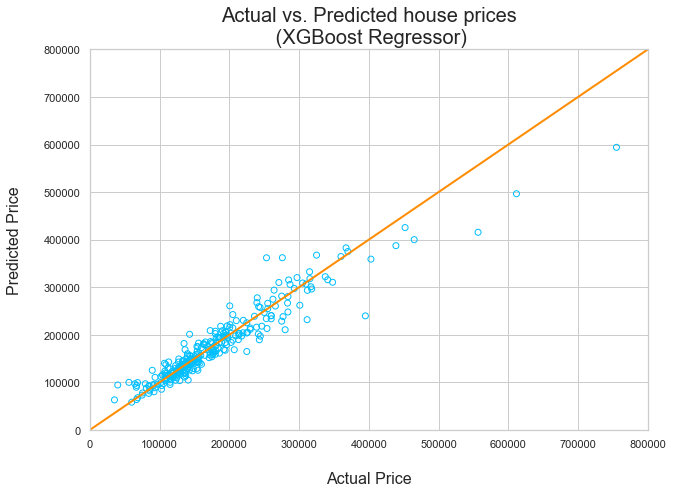

In [83]:
plt.figure()
plt.title("Actual vs. Predicted house prices\n (XGBoost Regressor)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_xgb_opt),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

After application of hyperparameter tuning, the Lasso model returned the best R^{2} score and the lowest RMSE value, achieving an accuracy of around 90.7%. Based on this, the optimized Lasso Regression model will be used to predict the Sale Price of houses from the test dataset. The predicted sale prices will be saved into a csv file named "submission.csv".

In [84]:
# Prediction of House Prices using the Optimal Lasso Regression Model

y_pred = np.exp(model_lasso_opt.predict(data_test_new))

output = pd.DataFrame({"Id": Id_test_list,
                       "SalePrice": y_pred})

output.head(10)

,Id,SalePrice
0,1461,"117,361.01"
1,1462,"156,765.56"
2,1463,"177,225.20"
3,1464,"191,032.88"
4,1465,"206,229.37"
5,1466,"170,722.64"
6,1467,"183,375.29"
7,1468,"158,327.51"
8,1469,"188,217.59"
9,1470,"119,829.51"


In [86]:
output.shape

(1459, 2)

In [85]:
# Save the output
output.to_csv("submission.csv", index=False)